In [0]:
#Importamos Librerías:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image
import math 

In [0]:
#La configuración y los pesos de la red:
!wget "https://pjreddie.com/media/files/yolov3.weights"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

--2020-05-15 01:35:37--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  1.78MB/s    in 3m 5s   

2020-05-15 01:38:42 (1.28 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-05-15 01:38:43--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2020

In [0]:
#Primeras pruebas de transformación:
#Leemos la imagen a corregir
img = cv2.imread('social_distance.jpg')
img = img[:,:,::-1]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

puntos = np.float32([[570, 119],[740, 170],[430, 523], [140, 410]])
imgDibujo = img.copy()
for i in range(0, 4):
  cv2.circle(imgDibujo, tuple(puntos[i]), 5, (255,0,0), -1)

pts = puntos.reshape((-1,1,2))
cv2.polylines(imgDibujo, [pts.astype(np.int32)], True, (0,255,0), thickness=2)
plt.figure(figsize=(10,10))
plt.imshow(imgDibujo)
plt.show()

width = 171
height = 480

# Hacemos la transformacion
target = np.float32([[0,0],[width,0],[width,height],[0,height]])

matrix = cv2.getPerspectiveTransform(puntos, target)
size = 200, 200, 3
m = np.zeros(size, dtype=np.uint8)

result = cv2.warpPerspective(img, matrix, (width,height))

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

In [0]:
#Ingresamos los parámetros de inicialización.
confidence_threshold = 0.5  #Confidence threshold
nms_threshold = 0.4   #Non-maximum suppression threshold
inpWidth = 608       #Tamaño de imagen de entrada.
inpHeight = 608      #Tamaño de imagen de salida.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
model = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [0]:
#Obtenemos la última capa.
layer_names = model.getLayerNames()
output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]
#Leemos la imagen o frame de video.
image = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB)
#Creamos un blob (formateamos la imagen de ingreso)
blob = cv2.dnn.blobFromImage(image, 1/255., (inpWidth, inpHeight), [0,0,0], 1, crop=False)
#Ingresamos el blob a la red y extraemos los resultados de la última capa.
model.setInput(blob)
outputs = model.forward(output_names)
#Aplicamos Non Maximum Supresion.
img_height = image.shape[0]
img_width = image.shape[1]
classIds = []
confidences = []
dimensions_list = []
boxes = []
for results in outputs:
  for detection in results:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > confidence_threshold:
      center_x = int(detection[0] * img_width)
      center_y = int(detection[1] * img_height)
      width = int(detection[2] * img_width)
      height = int(detection[3] * img_height)
      left = int(center_x - width / 2)
      top = int(center_y - height / 2)
      classIds.append(classId)
      confidences.append(float(confidence))
      boxes.append([left, top, width, height])

indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

#Encontramos la lista de boxes:
for index in indices:
  index = index[0]
  i_class = classes[classIds[index]]
  if i_class == 'person':  
    box = boxes[index]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    dimensions_list.append([left, width, top, height])
dimensions_list

In [0]:
#Calculamos la distancia y ploteamos los boxes que se encuentran proximos en rojo.
distance_thrs = 100
i = 0
for i in range(len(dimensions_list)):
  j = 0
  count = 0
  left = dimensions_list[i][0]
  width = dimensions_list[i][1]
  top = dimensions_list[i][2]
  height = dimensions_list[i][3]
  
  centroid_x = left + int(width/2)
  centroid_y = top + int(height/2)

  for j in range(len(dimensions_list)):
    left_2 = dimensions_list[j][0]
    width_2 = dimensions_list[j][1]
    top_2 = dimensions_list[j][2]
    height_2 = dimensions_list[j][3]

    centroid_x_2 = left_2 + int(width_2/2)
    centroid_y_2 = top_2 + int(height_2/2)

    distance = math.sqrt((centroid_x_2 - centroid_x)**2 + (centroid_y_2 - centroid_y)**2)
    if ((distance > 0) and (distance < distance_thrs)):
        count = count + 1

  if (count < 1):
    cv2.rectangle(image, (left, top), (left + width, top + height), (0,0,255), 2)
    cv2.circle(image, tuple([centroid_x,centroid_y]), 5, (255,0,0), -1)
  else:
    cv2.rectangle(image, (left, top), (left + width, top + height), (255,0,0), 2)
    cv2.circle(image, tuple([centroid_x,centroid_y]), 5, (255,0,0), -1)

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()
#Referencia: https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/

In [0]:
#SOCIAL DISTANCE DETECTOR:

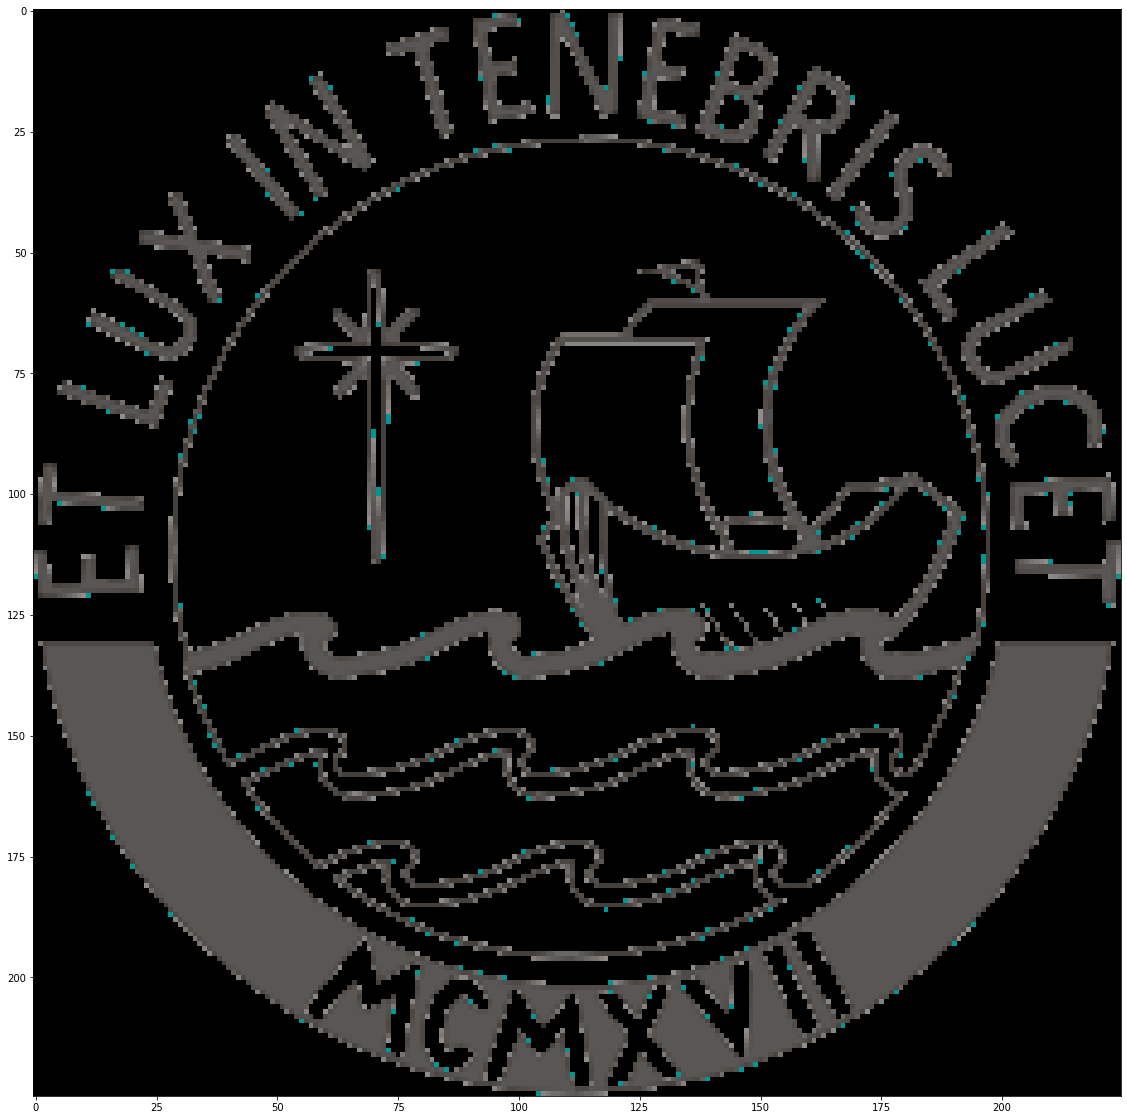

In [149]:
#Formatear Imagen para convertir 1s a 0s:
logo_pucp = cv2.imread("pucp.png")
gray = cv2.cvtColor(logo_pucp, cv2.COLOR_BGR2RGB)
blur = cv2.GaussianBlur(logo_pucp,(5,5),0)
ret, thresh = cv2.threshold(logo_pucp, 150, 150, cv2.COLOR_BGR2RGB)
logo_pucp[thresh == 0] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
erosion = cv2.erode(logo_pucp, kernel, iterations = 1)
plt.figure(figsize=(20,20))
plt.imshow(logo_pucp)
plt.show()

In [0]:
def Calculate_Distance_Perspective(centroid_x_2,centroid_y_2,centroid_x,centroid_y):
  
  #Matriz de homografía resultante:
  matrix_transf = np.array([[ 1.14199333e+00,  6.94076400e+00,  8.88203441e+02],
       [-5.13279159e-01,  7.26783411e+00,  1.02467130e+03],
       [ 9.79674124e-07,  1.99580075e-03,  1.00000000e+00]])
  
  #Aplicamos la transformación a los centroides.
  points_out = np.array([[[centroid_x_2, centroid_y_2], [centroid_x,centroid_y]]], dtype='float32')
  points_transf = cv2.perspectiveTransform(points_out, matrix_transf)
  
  #Calculamos los parámetros necesarios:
  distance = math.sqrt((points_transf[0][0][0] - points_transf[0][1][0])**2 + (points_transf[0][0][1] - points_transf[0][1][1])**2)
  centroid_eagle_x = points_transf[0][1][0]
  centroid_eagle_y = points_transf[0][1][1]

  return distance, centroid_eagle_x, centroid_eagle_y

In [0]:
def Compute_Eagle_View(img_color):
  #Parámetros de Inicialización:
  image = img_color
  confidence_threshold = 0.5  #Confidence threshold
  nms_threshold = 0.4   #Non-maximum suppression threshold
  inpWidth = 608       #Tamaño de imagen de entrada.
  inpHeight = 608      #Tamaño de imagen de salida.
  #Parametros de Posición para extraer el área donde se proyectan los puntos:
  cut_posX_min,cut_posX_max = 2000,3400 
  cut_posY_min,cut_posY_max = 200,2800
  distance_thrs = 100
  #Background de la vista de águila y background total.
  background_egle_view = np.zeros((3000, 4500, 3), dtype=np.uint8)
  background = np.ones((1200, 2600, 3), dtype=np.uint8)*100
  #Cargamos la imagen de logo y modificamos su tamaño:
  pucp_logo = logo_pucp
  pucp_logo = cv2.resize(pucp_logo,(400,400))

  #Creamos un blob (formateamos la imagen de ingreso)
  blob = cv2.dnn.blobFromImage(image, 1/255., (inpWidth, inpHeight), [0,0,0], 1, crop=False)
  #Ingresamos el blob a la red y extraemos los resultados de la última capa.
  layer_names = model.getLayerNames()
  output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]
  model.setInput(blob)
  results = model.forward(output_names)
  #Aplicamos Non Maximum Supresion.
  img_height = image.shape[0]
  img_width = image.shape[1]
  classIds = []
  confidences = []
  dimensions_list = []
  boxes = []
  for result in results:
    for detection in result:
      scores = detection[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confidence_threshold:
        center_x = int(detection[0] * img_width)
        center_y = int(detection[1] * img_height)
        width = int(detection[2] * img_width)
        height = int(detection[3] * img_height)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])

  indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

  #Encontramos la lista de boxes:
  for index in indices:
    index = index[0]
    i_class = classes[classIds[index]]
    if i_class == 'person':  
      box = boxes[index]
      left = box[0]
      top = box[1]
      width = box[2]
      height = box[3]
      dimensions_list.append([left, width, top, height])

  #Calculamos la distancia y ploteamos los boxes que se encuentran proximos en rojo.
  i = 0
  for i in range(len(dimensions_list)):
    j = 0
    count = 0
    left = dimensions_list[i][0]
    width = dimensions_list[i][1]
    top = dimensions_list[i][2]
    height = dimensions_list[i][3]
    centroid_x = left + int(width/2)
    centroid_y = top + int(height/2)

    for j in range(len(dimensions_list)):
      left_2 = dimensions_list[j][0]
      width_2 = dimensions_list[j][1]
      top_2 = dimensions_list[j][2]
      height_2 = dimensions_list[j][3]
      centroid_x_2 = left_2 + int(width_2/2)
      centroid_y_2 = top_2 + int(height_2/2)

      distance, centroid_eagle_x, centroid_eagle_y  = Calculate_Distance_Perspective(centroid_x_2,centroid_y_2,centroid_x,centroid_y)
 
      if (distance < distance_thrs):
          count = count + 1

    if (count == 1):
      cv2.rectangle(image, (left, top), (left + width, top + height), (0,255,0), 2)
      cv2.circle(background_egle_view, tuple([centroid_eagle_x,centroid_eagle_y]), 25, (0,255,0), -1)
    else:
      cv2.rectangle(image, (left, top), (left + width, top + height), (255,0,0), 2)
      cv2.circle(background_egle_view, tuple([centroid_eagle_x,centroid_eagle_y]), 25, (255,0,0), -1)

  #Recortamos la vista:
  view_birdEye = background_egle_view[cut_posY_min:cut_posY_max, cut_posX_min:cut_posX_max, :]
  #Escalamos la vista y agregamos marca de agua:
  black_board= cv2.resize(view_birdEye, (600,1000))
  view_birdEye = cv2.resize(view_birdEye, (600,1000))
  view_birdEye[250:650,100:500,:] = pucp_logo
  view_birdEye_water = black_board.copy()
  cv2.addWeighted(view_birdEye, 0.4, view_birdEye_water, 0.6, 0, view_birdEye_water) 
  #Coloreamos:
  background[0:120, : ] = 255
  # Imagen original:
  overlay = image.copy()
  weigh_imgOri, high_imgOri, _ = overlay.shape
  pos_x_imgOri, pos_y_imgOri = 120, 0
  background[pos_x_imgOri:pos_x_imgOri+weigh_imgOri, pos_y_imgOri:pos_y_imgOri+high_imgOri ] = overlay
  #Eagle View:
  overlay = view_birdEye_water.copy()
  weigh_imgOri, high_imgOri, _ = overlay.shape
  pos_x_imgOri, pos_y_imgOri = 160, 1960
  background[pos_x_imgOri:pos_x_imgOri+weigh_imgOri, pos_y_imgOri:pos_y_imgOri+high_imgOri ] = overlay
  
  #Imprimimos la figura final:
  plt.figure(figsize=(20,20))
  plt.imshow(background)
  plt.show()

  return background

In [0]:
%%time
video = cv2.VideoCapture('TownCentreXVID.avi')
W = None
H = None
writer = None

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]

	# Inicializar el writer
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output_video_test.avi', fourcc, 30, (W, H), True)

  img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  img_result = Compute_Eagle_View(img_color)
  if writer is not None:
    writer.write(img_result[:,:,::-1])      

if writer is not None:
  writer.release()

video.release()

# Ver los resultados en la carpeta multimedia al ejecutar